# Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Carregando dados

In [10]:
input_path = "/content/csv_data_ted.csv"
assert os.path.exists(input_path), f"Arquivo não encontrado: {input_path}"

# Leitura e limpeza
df = pd.read_csv(input_path)
pd.options.display.float_format = '{:,.2f}'.format
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# DataFrame

In [11]:
col_map = {"price": None,"cost": None,"volume": None,"stock": None,
           "competitor_price": None,"rating": None,"return_rate": None,
           "category": None,"product_name": None,"elasticity": None}

for c in df.columns:
    low = c.lower()
    if "price" in low and col_map["price"] is None and ("competitor" not in low):
        col_map["price"] = c
    if ("cost" in low or "custo" in low) and col_map["cost"] is None:
        col_map["cost"] = c
    if any(x in low for x in ["volume","units_sold","sold","sales","units_sold_last_month"]) and col_map["volume"] is None:
        col_map["volume"] = c
    if any(x in low for x in ["stock","inventory","qty_on_hand","quantity","stock_level"]) and col_map["stock"] is None:
        col_map["stock"] = c
    if "competitor" in low and col_map["competitor_price"] is None:
        col_map["competitor_price"] = c
    if "rating" in low and col_map["rating"] is None:
        col_map["rating"] = c
    if "return" in low and col_map["return_rate"] is None:
        col_map["return_rate"] = c
    if "category" in low and col_map["category"] is None:
        col_map["category"] = c
    if any(x in low for x in ["product_name","name","sku"]) and col_map["product_name"] is None:
        col_map["product_name"] = c
    if "elastic" in low and col_map["elasticity"] is None:
        col_map["elasticity"] = c

# Preparação
work = df.copy()

def get_col(name):
    col = col_map.get(name)
    if col and col in work.columns:
        return work[col]
    else:
        return pd.Series([np.nan]*len(work), index=work.index)

if col_map.get('product_name') and col_map['product_name'] in work.columns:
    work['product_id'] = work[col_map['product_name']].astype(str)
else:
    work['product_id'] = ['PID_'+str(i) for i in range(len(work))]

work['price'] = pd.to_numeric(get_col('price'), errors='coerce').fillna(0)
work['cost'] = pd.to_numeric(get_col('cost'), errors='coerce').fillna(0)
work['volume'] = pd.to_numeric(get_col('volume'), errors='coerce').fillna(0)
work['stock'] = pd.to_numeric(get_col('stock'), errors='coerce').fillna(0)
work['competitor_price'] = pd.to_numeric(get_col('competitor_price'), errors='coerce')
work['rating'] = pd.to_numeric(get_col('rating'), errors='coerce')
work['return_rate'] = pd.to_numeric(get_col('return_rate'), errors='coerce')
work['category'] = get_col('category').astype(str).fillna('unknown')
work['product_name'] = get_col('product_name').astype(str).fillna('unknown')
work['elasticity_raw'] = pd.to_numeric(get_col('elasticity'), errors='coerce')

# Inferência de categoria
def infer_category(row):
    cat = str(row['category']).lower() if pd.notna(row['category']) else 'unknown'
    name = str(row['product_id']).lower()
    if cat!='unknown' and cat!='nan' and cat!='none':
        return cat
    if any(k in name for k in ['iphone','mac','notebook','laptop']):
        return 'electronics_premium'
    if any(k in name for k in ['galaxy','tablet','camera','tv','smartphone']):
        return 'electronics_mainstream'
    if any(k in name for k in ['cabo','charger','fone','headset','acessorio','case','carregador']):
        return 'accessory'
    return 'other'

work['category_inferred'] = work.apply(infer_category, axis=1)

# Elasticidade

In [12]:
def assign_elasticity(row):
    if pd.notna(row['elasticity_raw']):
        return row['elasticity_raw']
    cat = row['category_inferred']
    if 'premium' in cat:
        return -0.8
    if 'mainstream' in cat:
        return -1.2
    if 'access' in cat or 'accessory' in cat:
        return -2.0
    return -1.2

work['elasticity'] = work.apply(assign_elasticity, axis=1)

# Métricas base
work['margin_pct'] = np.where(work['price']>0, (work['price'] - work['cost'])/work['price']*100, 0)
work['current_profit'] = (work['price'] - work['cost']) * work['volume']

def comp_position(row):
    cp = row['competitor_price']
    if pd.isna(cp) or cp==0:
        return 'unknown'
    if row['price'] < cp:
        return 'below'
    if abs(row['price'] - cp) <= 1e-6:
        return 'equal'
    return 'above'
work['position_vs_competitor'] = work.apply(comp_position, axis=1)

# Simulações de preço
changes = [-0.15, -0.10, -0.05, 0.05, 0.10, 0.15]
sim_rows = []

for idx, r in work.iterrows():
    for ch in changes:
        new_price = r['price'] * (1 + ch)
        if new_price < r['cost']:
            new_price = r['cost']
        new_volume = r['volume'] * (1 + ch * r['elasticity'])
        if new_volume < 0: new_volume = 0
        new_profit = (new_price - r['cost']) * new_volume
        delta_profit = new_profit - r['current_profit']
        sim_rows.append({
            'index': idx,
            'product_id': r['product_id'],
            'category': r['category_inferred'],
            'price_old': r['price'],
            'price_new': new_price,
            'pct_change': ch,
            'elasticity': r['elasticity'],
            'volume_old': r['volume'],
            'volume_new': new_volume,
            'cost': r['cost'],
            'current_profit': r['current_profit'],
            'new_profit': new_profit,
            'delta_profit': delta_profit,
            'position_vs_competitor': r['position_vs_competitor'],
            'margin_pct_old': r['margin_pct']
        })

sim_df = pd.DataFrame(sim_rows)

if col_map['product_name'] and col_map['product_name'] in work.columns:
    work['product_name'] = work[col_map['product_name']].astype(str)
else:
    work['product_name'] = work['product_id']
sim_df = sim_df.merge(work[['product_id','product_name']], on='product_id', how='left')

# Seleção dos melhores
best_each_idx = sim_df.groupby('index')['delta_profit'].idxmax().dropna().astype(int)
best_each = sim_df.loc[best_each_idx].copy().sort_values('delta_profit', ascending=False)
top_positive = best_each[best_each['delta_profit']>0].head(10)


# Print Recomendações

In [13]:
print("\n Top 10 Oportunidades de Ajuste de Preço:\n")
for _, r in top_positive.iterrows():
    change_pct = round(r['pct_change'] * 100, 1)
    print(f" Produto: {r['product_name']} "
          f"(Categoria: {r['category']}) — "
          f"Recomendação: {'aumentar' if change_pct > 0 else 'reduzir'} preço em {abs(change_pct)}% "
          f"→ Lucro adicional estimado: +R$ {r['delta_profit']:,.2f}")

    # Salva resultados
out_sim = "/content/price_simulation_results.csv"
out_summary = "/content/price_simulation_summary.csv"
sim_df.to_csv(out_sim, index=False)
top_positive.to_csv(out_summary, index=False)

print("\nArquivos salvos:")
print("→ Simulações completas:", out_sim)
print("→ Top recomendações:", out_summary)


 Top 10 Oportunidades de Ajuste de Preço:

 Produto: Apple Smartphone Modelo 1 (Categoria: smartphones) — Recomendação: aumentar preço em 15.0% → Lucro adicional estimado: +R$ 91,458.20
 Produto: Apple Smartphone Modelo 15 (Categoria: smartphones) — Recomendação: aumentar preço em 15.0% → Lucro adicional estimado: +R$ 84,638.05
 Produto: Apple Smartphone Modelo 8 (Categoria: smartphones) — Recomendação: aumentar preço em 15.0% → Lucro adicional estimado: +R$ 72,355.32
 Produto: Samsung Smartphone Modelo 6 (Categoria: smartphones) — Recomendação: aumentar preço em 15.0% → Lucro adicional estimado: +R$ 31,635.00
 Produto: Samsung Smartphone Modelo 3 (Categoria: smartphones) — Recomendação: aumentar preço em 15.0% → Lucro adicional estimado: +R$ 19,935.07
 Produto: Samsung Smartphone Modelo 9 (Categoria: smartphones) — Recomendação: aumentar preço em 15.0% → Lucro adicional estimado: +R$ 19,547.52
 Produto: Samsung Smartphone Modelo 13 (Categoria: smartphones) — Recomendação: aumentar pr

# Gráfico

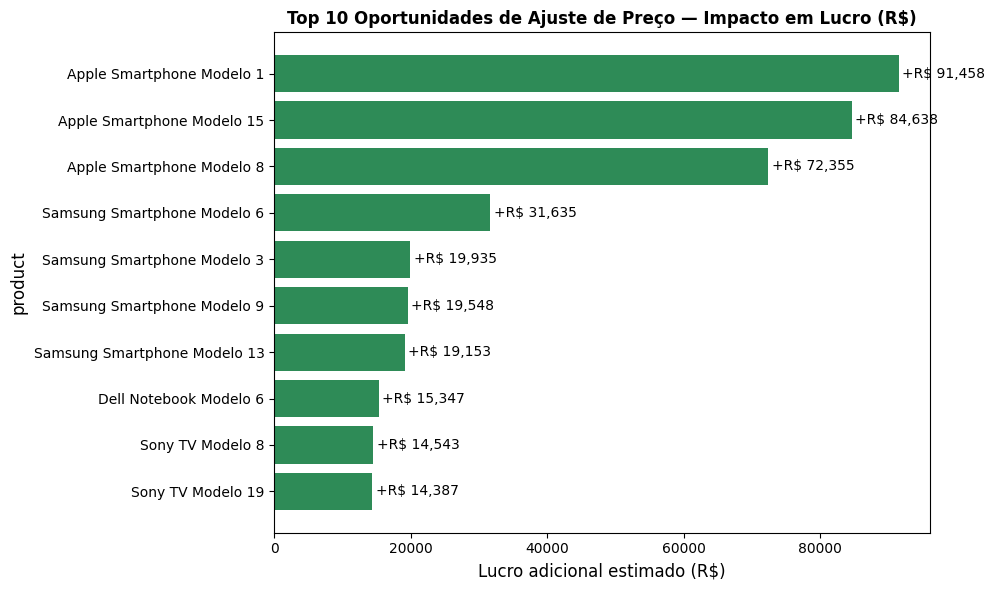

In [14]:
plt.figure(figsize=(10, 6))
plt.barh(
    top_positive['product_name'],
    top_positive['delta_profit'],
    color='seagreen'
)
plt.gca().invert_yaxis()
plt.title("Top 10 Oportunidades de Ajuste de Preço — Impacto em Lucro (R$)", fontsize=12, weight='bold')
plt.xlabel("Lucro adicional estimado (R$)", fontsize=12)
plt.ylabel("product", fontsize=12)
for i, v in enumerate(top_positive['delta_profit']):
    plt.text(v + 500, i, f"+R$ {v:,.0f}", va='center')
plt.tight_layout()
plt.show()
